In [57]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [58]:
train_path = '../../autodl-tmp/face-wrinkles/train'
val_path = '../../autodl-tmp/face-wrinkles/valid'
test_path = '../../autodl-tmp/face-wrinkles/test'
with open(os.path.join(train_path, "_annotations.coco.json"), 'r') as f:
    train_annotations = json.load(f)
print(train_annotations.keys())
with open(os.path.join(val_path, "_annotations.coco.json"), 'r') as f:
    val_annotations = json.load(f)
with open(os.path.join(test_path, "_annotations.coco.json"), 'r') as f:
    test_annotations = json.load(f)

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [59]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import numpy as np
import cv2

In [60]:
class WrinkleDataset(Dataset):
    def __init__(self, data_path, annotations, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        self.image_id_to_filename = {img['id']: img['file_name'] for img in annotations['images']}
        self.image_id_to_annotations = {}
        for ann in annotations['annotations']:
            image_id = ann['image_id']
            if image_id not in self.image_id_to_annotations:
                self.image_id_to_annotations[image_id] = []
            self.image_id_to_annotations[image_id].append(ann)
        
        self.image_ids = list(self.image_id_to_filename.keys())

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.data_path, self.image_id_to_filename[image_id])
        
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"File not found: {image_path}. Skipping...")
            return self.__getitem__((idx + 1) % len(self))
        
        if image_id not in self.image_id_to_annotations:
            print(f"No annotations found for image ID {image_id}. Skipping...")
            return self.__getitem__((idx + 1) % len(self))
        
        annotations = self.image_id_to_annotations[image_id]

        masks = []
        boxes = []
        labels = []
        for ann in annotations:
            polygons = ann['segmentation']
            mask = np.zeros((image.height, image.width), dtype=np.uint8)
            for polygon in polygons:
                polygon = np.array(polygon, dtype=np.int32).reshape((-1, 2))
                cv2.fillPoly(mask, [polygon], 1)
            masks.append(mask)
        
        pos = np.where(mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])

        labels.append(1)

        if masks:
            masks = np.stack(masks, axis=0)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        else:
            masks = torch.zeros((0, image.height, image.width), dtype=torch.uint8)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        
        if self.transform:
            image = self.transform(image)
        
        target = {"boxes": boxes, "masks": masks, "labels": labels}
        
        return image, target

In [61]:
transform = T.Compose([T.ToTensor()])

In [62]:
def collate_fn(batch):
    images, targets = zip(*batch)
    images = list(images)
    targets = list(targets)
    return images, targets

In [63]:
train_dataset = WrinkleDataset(train_path, train_annotations, transform=transform)
val_dataset = WrinkleDataset(val_path, val_annotations, transform=transform)
test_dataset = WrinkleDataset(test_path, test_annotations, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, num_workers=2, shuffle=True, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, num_workers=2, shuffle=False, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=2, shuffle=False, pin_memory=True, collate_fn=collate_fn)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

In [65]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 4)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 4)

In [66]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [67]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

In [68]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        train_loss += losses.item()
    
    train_loss /= len(train_loader)
    print(f"Epoch: {epoch+1}, Training Loss: {train_loss}")

    # Validation
    #model.eval()
    val_loss = 0
    with torch.no_grad():
        model.train()
        for images, targets in val_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
    model.eval()

    val_loss /= len(val_loader)
    print(f"Epoch: {epoch+1}, Validation Loss: {val_loss}")

No annotations found for image ID 342. Skipping...
Epoch: 1, Training Loss: 0.48090840904447046
Epoch: 1, Validation Loss: 0.33062895680918836
No annotations found for image ID 342. Skipping...
Epoch: 2, Training Loss: 0.3107089814527527
Epoch: 2, Validation Loss: 0.32909095174435415
No annotations found for image ID 342. Skipping...
Epoch: 3, Training Loss: 0.2791159172420916
Epoch: 3, Validation Loss: 0.30126914901263785
No annotations found for image ID 342. Skipping...
Epoch: 4, Training Loss: 0.2766420723384489
Epoch: 4, Validation Loss: 0.2822971712007667
No annotations found for image ID 342. Skipping...
Epoch: 5, Training Loss: 0.25592782963877136
Epoch: 5, Validation Loss: 0.31403358009728516
No annotations found for image ID 342. Skipping...
Epoch: 6, Training Loss: 0.24382949276300875
Epoch: 6, Validation Loss: 0.26943988849719364
No annotations found for image ID 342. Skipping...
Epoch: 7, Training Loss: 0.2479705838891475
Epoch: 7, Validation Loss: 0.24830229557824857
No a

In [69]:
model_path = "maskrcnn_wrinkle_detection.pth"
torch.save(model.state_dict(), model_path)

In [70]:
model.eval()
test_loss = 0
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        test_loss += losses.item()
        model.eval()
    
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

Test Loss: 0.4594445859010403


In [71]:
def load_image(image_path, device, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)  # Add batch dimension and move to device
    
    return image

In [72]:
def visualize_predictions(image, class_names, outputs):
    """Visualize the predictions"""
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax = plt.gca()
    for box, label, score in zip(outputs['boxes'], outputs['labels'], outputs['scores']):
        if score > 0.8:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f"{class_names[label.item()]}:{score:.2f}", color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

In [73]:
class_names = ['forehead','frown','wrinkle']

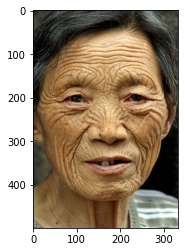

In [74]:
model.eval()
unseen_image_path = "images/wrinkles/face.jpg"
image = load_image(unseen_image_path, device, transform)

with torch.no_grad():
    outputs = model([image])[0]

visualize_predictions(image, class_names, outputs)

In [75]:
# def show_predictions(img_tensor, prediction, threshold=0.5):
#     """
#     Visualize the image with bounding boxes and masks.
#     """
#     fig, ax = plt.subplots(1, figsize=(12, 9))
#     img = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

#     img = img - img.min()
#     img = img / img.max()

#     # Plot the image
#     ax.imshow(img)

#     for i in range(len(prediction[0]['boxes'])):
#         score = prediction[0]['scores'][i].cpu().numpy()
#         if score > threshold:
#             # Extract the bounding box coordinates
#             box = prediction[0]['boxes'][i].cpu().numpy()
#             xmin, ymin, xmax, ymax = box

#             # Draw the bounding box
#             rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='r', linewidth=2)
#             ax.add_patch(rect)

#             # Extract the mask
#             mask = prediction[0]['masks'][i, 0].cpu().numpy()
#             mask = mask > threshold

#             # Apply the mask to the image
#             img[mask] = img[mask] * [0.5, 0.5, 0.5] + [0.5, 0, 0]

#     ax.imshow(img)
#     plt.show()

In [76]:
# model.eval()
# with torch.no_grad():
#     unseen_image_path = 'images/wrinkles/face.jpg'
#     img = Image.open(unseen_image_path).convert("RGB")
#     img = transform(img).unsqueeze(0).to(device)
#     prediction = model(img)
#     print(prediction)

# show_predictions(img, prediction)